In [1]:
from large_gcs.graph.cost_factory import create_l2norm_edge_cost, create_l2norm_squared_edge_cost
from large_gcs.example_graphs.utils.spp_shape_gcs_utils import generate_spp_shape_gcs, load_spp_shape_gcs, SppShapeGcsGeneratorParams
from large_gcs.algorithms.gcs_dijkstra import GcsDijkstra
from large_gcs.algorithms.search_algorithm import AlgVisParams
import matplotlib.pyplot as plt
import os
import numpy as np

Sampling points uniformly within the workspace...
Processing samples into convex sets...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 174.10it/s]


Calculating distance matrix...
Adding edges to vertices...


100%|██████████| 3/3 [00:00<00:00, 19122.97it/s]


Saving graph data...
Adding vertices and edges to graph...
Adding points as vertices to the graph...


100%|██████████| 2/2 [00:00<00:00, 5289.16it/s]


Adding ellipsoids as vertices to the graph...


100%|██████████| 481/481 [00:00<00:00, 18970.72it/s]


Adding polyhedra as vertices to the graph...


100%|██████████| 519/519 [00:05<00:00, 94.91it/s]


Adding edges to the graph...


100%|██████████| 1001/1001 [00:00<00:00, 37099.04it/s]


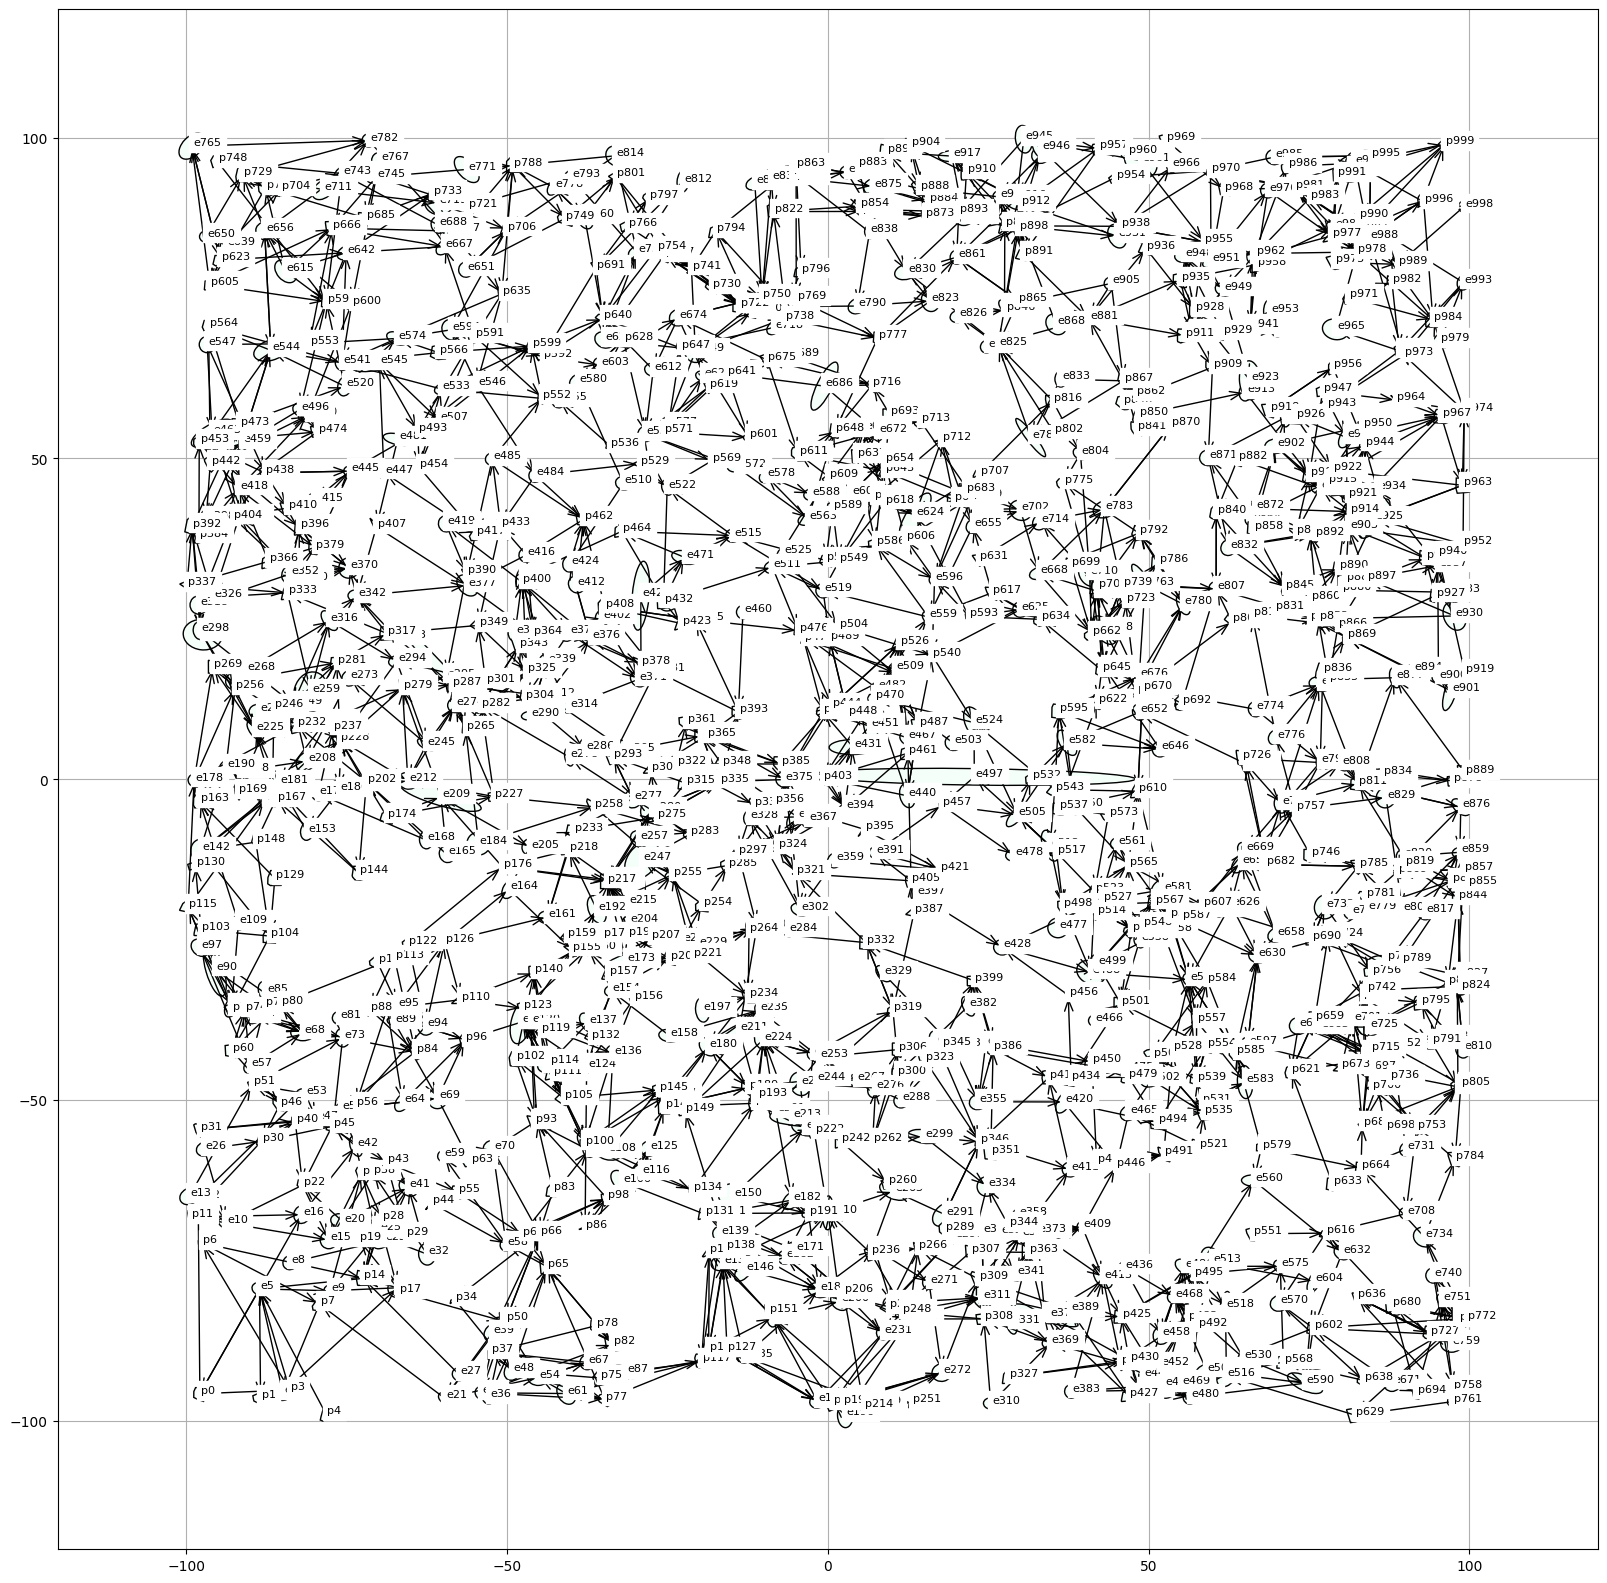

In [2]:
# params = SppShapeGcsGeneratorParams(should_save=True,
#                                     random_seed = 804454)
workspace_radius=100
params = SppShapeGcsGeneratorParams(
    n_sets=1000,
    workspace=([-workspace_radius, workspace_radius], [-workspace_radius, workspace_radius]),
    source=(0,0),
    target=(workspace_radius * 0.7, workspace_radius * 0.7),
    set_scale=1.2,
    k_nearest_edges=(1,4),
    k_nearest_pool=20,
    random_seed=490052,
    should_save=True,
)
file_name = f"spp_{params.dim}d_v{params.n_sets}_shape_gcs.npy"
graph_file = os.path.join(os.environ['PROJECT_ROOT'], "large_gcs", "example_graphs",
                    file_name)
params.save_path = graph_file

In [ ]:
# G = generate_spp_shape_gcs(params)

# # draw convex sets and edges
# plt.figure(figsize=(20,20))
# G.plot_sets()
# G.plot_edges()
# G.plot_set_labels()
# plt.grid()
# plt.xlim(params.workspace[0]* 1.2)
# plt.ylim(params.workspace[1]* 1.2)
# plt.show()

Adding points as vertices to the graph...


100%|██████████| 2/2 [00:00<00:00, 4652.58it/s]


Adding ellipsoids as vertices to the graph...


100%|██████████| 481/481 [00:00<00:00, 20492.65it/s]


Adding polyhedra as vertices to the graph...


100%|██████████| 519/519 [00:05<00:00, 100.83it/s]


Adding edges to the graph...


100%|██████████| 1001/1001 [00:00<00:00, 10164.08it/s]


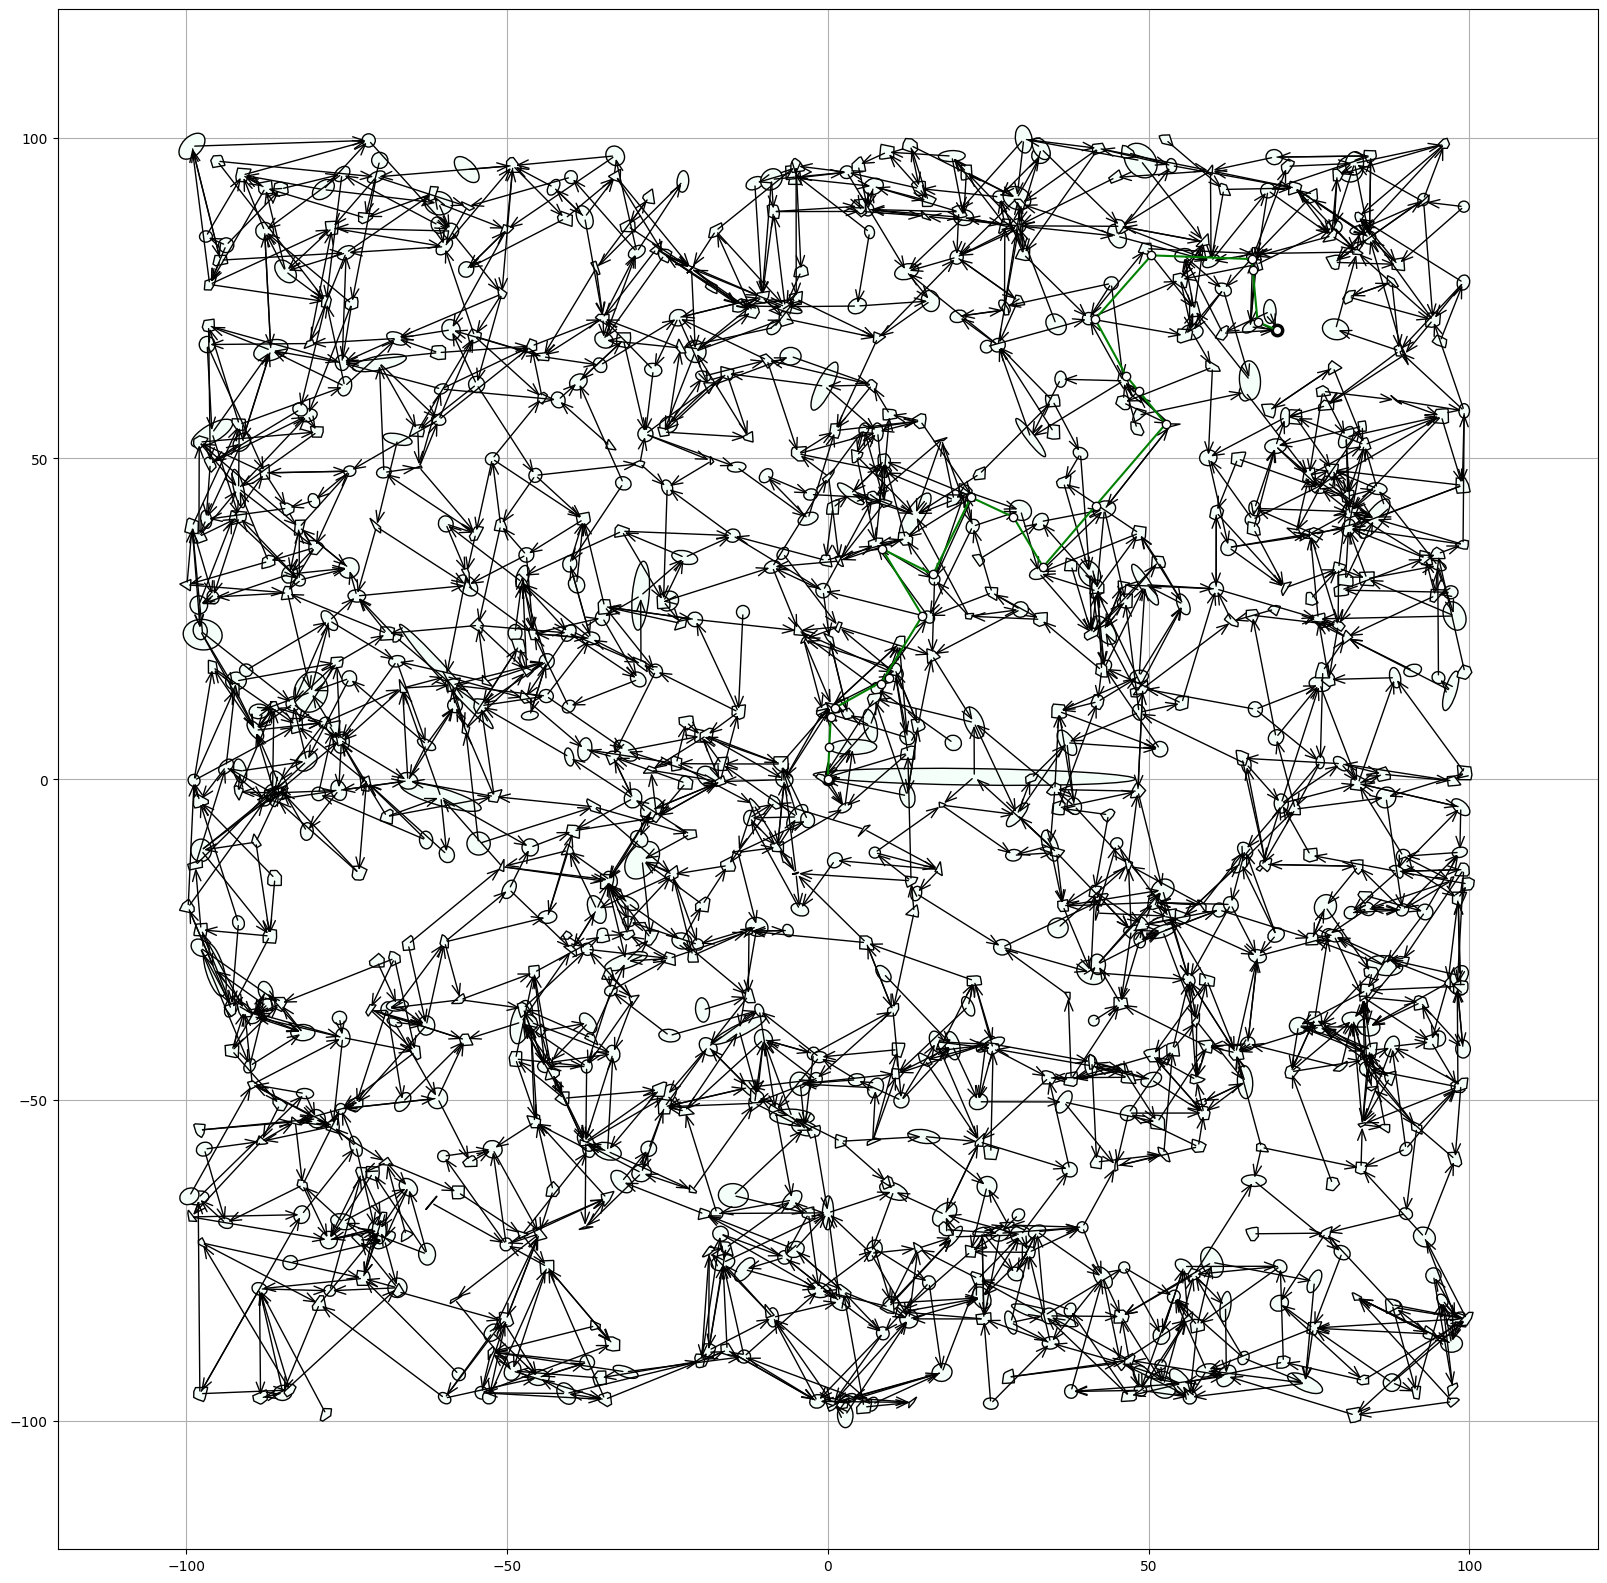

In [3]:
G = load_spp_shape_gcs(graph_file, create_l2norm_edge_cost)
sol = G.solve_shortest_path()

# draw convex sets and edges
plt.figure(figsize=(20,20))
G.plot_sets()
G.plot_edges()
# G.plot_set_labels()
G.plot_path(sol.path)
plt.grid()
plt.xlim(np.array(params.workspace[0])* 1.2)
plt.ylim(np.array(params.workspace[1])* 1.2)

plt.show()

In [4]:
data = np.load(graph_file, allow_pickle=True).item()
print(data["params"])

SppShapeGcsGeneratorParams(dim=2, n_sets=1000, source=array([0, 0]), target=array([70., 70.]), n_st_edges=3, workspace=array([[-100,  100],
       [-100,  100]]), set_scale=1.2, k_nearest_edges=array([1, 4]), k_nearest_pool=20, n_polyhedron_vertices=array([ 4, 20]), random_seed=490052, save_path='/Users/chewchiashaoyuan/Documents/Software/large_gcs/large_gcs/example_graphs/spp_2d_v1000_shape_gcs.npy', should_save=True)


In [ ]:
vid_file = os.path.join(os.environ['PROJECT_ROOT'], "output", "gcs_dijkstra", "gcs_dijkstra_spp_2d.mp4")
GcsDijkstra(G, AlgVisParams(output_path=vid_file)).run(animate=True)